In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
## Prototype

In [44]:
df = pd.read_pickle('transformer_noise.pkl')

In [46]:
# df.isna().sum()/df.shape[0] # Scope out roughly where we still have data

In [48]:
df['standard_prediction_correct'] = df['truth'] == df['standard_prediction']
path_length_columns = df.filter(regex='path_length').columns[:-5]

for path_length_column_name in path_length_columns:
    df[path_length_column_name] = df[path_length_column_name].fillna(df['standard_prediction'])
    df[path_length_column_name] = df[path_length_column_name].astype(int)
    correct_label = path_length_column_name.rstrip('_prediction') + '_correct'

    df[correct_label] = df[path_length_column_name] == df['truth']

In [49]:
corrects = df.filter(regex='correct').sum()
prop_corrects = (corrects/corrects.loc['standard_prediction_correct'])
prop_corrects = prop_corrects.filter(regex='path')
prop_corrects = prop_corrects.to_frame().reset_index()
prop_corrects['path_length'] = prop_corrects['index'].str.split('_').apply(lambda x: x[2]).astype(int)
prop_corrects = prop_corrects.drop(columns=['index'])
prop_corrects = prop_corrects.rename(columns={0: 'relative_accuracy'})

In [50]:
corrects

standard_prediction_correct    2868
path_length_0_correct          2897
path_length_1_correct          2875
path_length_2_correct          2795
path_length_3_correct          2736
path_length_4_correct          2720
path_length_5_correct          2743
path_length_6_correct          2766
path_length_7_correct          2792
path_length_8_correct          2809
path_length_9_correct          2846
path_length_10_correct         2871
path_length_11_correct         2887
path_length_12_correct         2894
path_length_13_correct         2885
path_length_14_correct         2891
path_length_15_correct         2876
dtype: int64

<Axes: xlabel='path_length'>

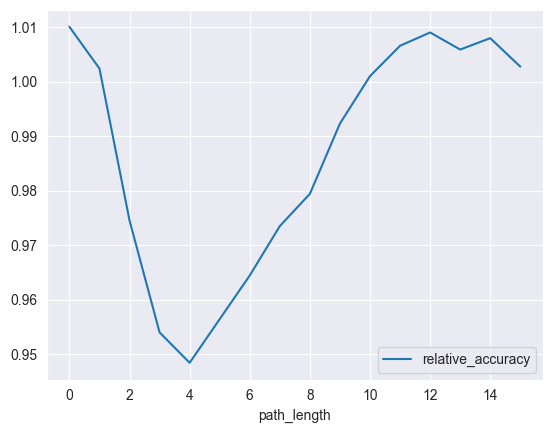

In [8]:
prop_corrects.plot('path_length',
              'relative_accuracy'
              )

In [53]:
from sklearn import metrics

### Functionify

In [130]:
def pre_process_df(df_path, max_path_length=15):
    df = pd.read_pickle(df_path)
    df['standard_prediction_correct'] = df['truth'] == df['standard_prediction']
    path_length_columns = df.filter(regex='path_length').columns

    max_index = max_path_length-len(path_length_columns)
    drop_path_length_columns = path_length_columns[max_index:]
    df = df.drop(columns=drop_path_length_columns)
    path_length_columns = path_length_columns[:max_index]

    for path_length_column_name in path_length_columns:
        # print(path_length_column_name)
        df[path_length_column_name] = df[path_length_column_name].fillna(df['standard_prediction'])
        df[path_length_column_name] = df[path_length_column_name].astype(int)
        correct_label = path_length_column_name.rstrip('_prediction') + '_correct'

        df[correct_label] = df[path_length_column_name] == df['truth']
    return df

def get_relative_accuracy(df):
    corrects = df.filter(regex='correct').sum()
    prop_corrects = (corrects/corrects.loc['standard_prediction_correct'])
    prop_corrects = prop_corrects.filter(regex='path')
    prop_corrects = prop_corrects.to_frame().reset_index()
    prop_corrects['path_length'] = prop_corrects['index'].str.split('_').apply(lambda x: x[2]).astype(int)
    prop_corrects = prop_corrects.drop(columns=['index'])
    prop_corrects = prop_corrects.rename(columns={0: 'relative_accuracy'})

    return prop_corrects

def get_relative_f1s(df):
    prediction_columns = df.filter(regex='path_length_[0-9]*_prediction')

    f1s = {'standard': metrics.f1_score(df['truth'], df['standard_prediction'], average='macro')
           }
    for pc in prediction_columns:
        name = pc.rstrip('_prediction')
        f1s[name] = metrics.f1_score(df['truth'], df[pc], average='macro')

    f1s = pd.DataFrame(data=f1s, index=['f1_score']).T
    relative_f1s = (f1s/f1s.iloc[0]).iloc[1:]
    relative_f1s = relative_f1s.reset_index().rename(columns={'index': 'path_length_str'})
    relative_f1s['path_length'] = relative_f1s['path_length_str'].str.lstrip('path_length_').astype(int)
    relative_f1s = relative_f1s.drop(columns='path_length_str')

    return relative_f1s

In [131]:
transformer = pre_process_df('transformer_noise.pkl')
gcn = pre_process_df('gcn_10.pkl')

In [132]:
transformer_acc = get_relative_accuracy(transformer)
gcn_acc = get_relative_accuracy(gcn)

Text(0.5, 0, 'Path Length')

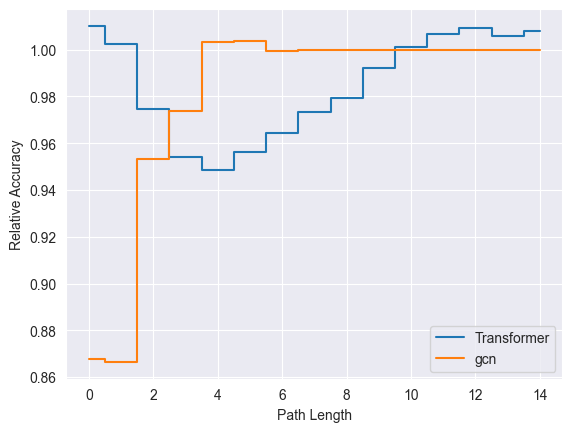

In [133]:
fig, ax = plt.subplots()
kwargs = {'drawstyle': 'steps-mid'}
transformer_acc.plot('path_length', 'relative_accuracy', ax=ax, label='Transformer', **kwargs)
gcn_acc.plot('path_length', 'relative_accuracy', ax=ax, label='gcn', **kwargs)

ax.set_ylabel('Relative Accuracy')
ax.set_xlabel('Path Length')

In [134]:
transformer_f1  = get_relative_f1s(transformer)
gcn_f1 = get_relative_f1s(gcn)

Text(0.5, 0, 'Path Length')

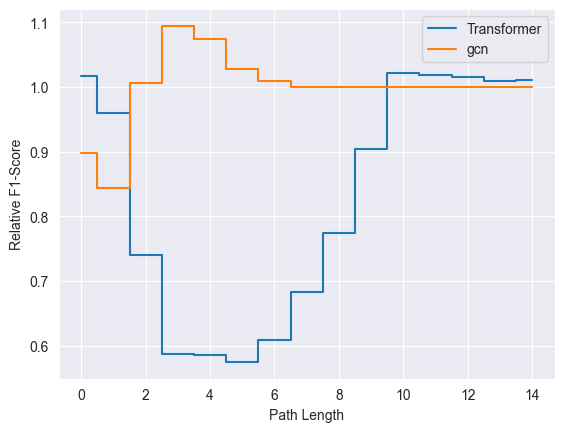

In [136]:
fig, ax = plt.subplots()
kwargs = {'drawstyle': 'steps-mid'}
transformer_f1.plot('path_length', 'f1_score', ax=ax, label='Transformer', **kwargs)
gcn_f1.plot('path_length', 'f1_score', ax=ax, label='gcn', **kwargs)

ax.set_ylabel('Relative F1-Score')
ax.set_xlabel('Path Length')